## Convolutional Neural Network Model for Audio Classification

In this notebook we are going to work with the pre-processed data from the previous notebook.<br/>
<br/>
We are not expecting to find the best possible model at this point, but we do expect to reach  the point at where we can start thinking in how to fine tune. Being that said, our objective in this part of our work will be to:<br/>
<br/>

* Achieve a model architecture that generalizes well: being able to represent the training and the test data
* A test accuracy perhaps over 90% with a differece with  training accuracy of less than 5%
* A model that does not overfit the training data

<br/>
If we achieve this objectives we will be in a good place to start thinking in more detailed optimizations.<br/>
<br/>
We'll discuss the model architecture, analyze the training history, evaluate the model with the test set and finally we are also going to explore the misclassified samples to see if we can discover some external reasons for the incorrect category prediction.<br/>
<br/>
<br/>

#### Load required libraries

In [425]:
import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import random
from datetime import datetime 

from keras import backend as keras_backend
from keras.models import Sequential
from keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint 

from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
# Define general variables

# Set your path to the dataset
us8k_path = os.path.abspath('./UrbanSound8K')
audio_path = os.path.join(us8k_path, 'audio')
metadata_path = os.path.join(us8k_path, 'metadata/UrbanSound8K.csv')

# Ensure "channel last" data format on Keras
keras_backend.set_image_data_format('channels_last')

#### Define helper functions

In [513]:
# Helper: Generates MFCC coefficients with Librosa 
def get_mfcc(filename, mfcc_max_padding=0):
    try:
        audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
                
        # Should we require padding?
        pad_width = mfcc_max_padding - mfccs.shape[1]
        if (mfcc_max_padding > 0 & mfccs.shape[1] < mfcc_max_padding):
            pad_width = mfcc_max_padding - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

    except Exception as e:
        print("Error parsing wavefile: ", filename)
        return None 
    return mfccs

# Given a file returns a list of prediction results
def predict_from_file(file_name, num_rows, num_columns, num_channels):
    # Note we use num_columns as our padding value!
    feature = get_mfcc(file_name, mfcc_max_padding=num_columns) 
    feature = feature.reshape(1, num_rows, num_columns, num_channels)
    predicted_vector = model.predict_classes(feature)
    predicted_class = le.inverse_transform(predicted_vector)
    predicted_proba = model.predict_proba(feature)[0]
    return [
        predicted_class,
        predicted_proba
    ]

# Reads the defaul directory for extra evaluation files and returns a pandas dataframe
def get_external_samples(base_path):
    files = []
    labels = []

    # Iterate category directories
    dirs = os.listdir(base_path)
    for d in dirs:
        category = d
        category_path = os.path.join(base_path, d)

        # Iterate files
        dir_files = os.listdir(category_path)

        for file in dir_files:
            file_path = os.path.join(category_path, file)
            files.append(file_path)
            labels.append(category)

    # Create dataframe
    return pd.DataFrame({ 'class': labels, 'file': files })
    
    
def plot_confusion_matrix(y_true, 
                          y_pred, 
                          classes, 
                          normalize=False, 
                          title=None, 
                          cmap=plt.cm.Blues,
                          size=(10,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
        
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    return [cm, ax]



# Expects a NumPy array with probabilities, retuns accuracy per class
def acc_per_class(np_probs_array):
    accs = []
    for idx in range(0, np_probs_array.shape[0]):
        correct = cm[idx][idx].astype(int)
        total = cm[idx].sum().astype(int)
        acc = (correct / total) * 100
        accs.append(acc)
    return accs

### Load data

In [4]:
# Pre-processed MFCC coefficients and labels & metadata

X = np.load("data/X-v1.npy")
y = np.load("data/y-v1.npy")

In [5]:
# Load the metadata from the generated CSV

metadata = pd.read_csv(metadata_path)

### Data preparation: features + metadata

#### Train / Test split

In [59]:
indexes = []
total = len(metadata)
indexes = list(range(0, total))

# Randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

# Split the metadata
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]
test_meta = metadata.iloc[test_split_idx]
train_meta = metadata.iloc[train_split_idx]

# Split the features the with the same indexes
X_test = np.take(X, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

# Print status
print("Test split: {} \t\t Train split: {}".format(len(test_meta), len(train_meta)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

Test split: 1746 		 Train split: 6986
X test shape: (1746, 40, 174) 	 X train shape: (6986, 40, 174)
y test shape: (1746,) 		 y train shape: (6986,)


#### One hot encode labels

In [63]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))


#### Reshape data

In [73]:
# How data should be organized
num_rows = 40
num_columns = 174 # Remember how we padded the data in the previous notebook?
num_channels = 1

# Reshape to fit the network input (channel last!)
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

10

### First model approach

#### Model description

At first I based on what I knew on image classifying architectures and some intuitions I had about convolutionin this type of data (MFCC coefficients of audio signals). This was my very first model:

* Conv2D [32 filters] (5x5) -> ReLU -> MaxPooling -> BatchNorm
* Conv2D [64 filters] (3x3) -> ReLU -> MaxPooling -> BatchNorm
* Conv2D [128 filters] (3x3) -> ReLU -> MaxPooling -> BatchNorm 
* Conv2D [512 filters] (3x3) -> ReLU -> MaxPooling -> BatchNorm
* Flatten -> Dense (256) -> BatchNorm -> Dropout(0.2)
* Dense (128) 
* Softmax (10)

The model overfitted very fast and almost any change that increasse the model size -in terms of trainable params- would bring even more overfitting. After simplifying the model as much as I could I finally got very acceptable results to start working with:

* Reduced kernel sizes as much as possible keeping a descreasing pattern
* Reduced filter amount to 50%
* Removed the flatten -> dense -> dense sequence and added global average pooling -as seen that others have had better training performance with no dense layers between the convolutions and the output softmax
* Added spatial dropout between convolutions

* Conv2D [32 filters] (3x3) -> ReLU -> BatchNorm -> Spatial Dropout -> MaxPooling
* Conv2D [64 filters] (3x3) -> ReLU -> BatchNorm -> Spatial Dropout -> MaxPooling
* Conv2D [128 filters] (2x2) -> ReLU -> BatchNorm -> Spatial Dropout -> MaxPooling
* Conv2D [512 filters] (2x2) -> ReLU -> BatchNorm -> Spatial Dropout -> MaxPooling
* Global average pooling 2D
* Softmax

This are the first positive results:


### Model #1 definition

In [71]:
model = Sequential()

# Conv 1
model.add(Conv2D(filters=16, kernel_size=(3,3), input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.2))

# Conv 2
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.2))
model.add(MaxPooling2D(pool_size=2))

# Conv 3
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.2))
model.add(MaxPooling2D(pool_size=2))

# Conv 4
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(SpatialDropout2D(0.2))
model.add(MaxPooling2D(pool_size=2))

# Reduces each h×w feature map to a single number by taking the average of all h,w values.
model.add(GlobalAveragePooling2D())

# Softmax output
model.add(Dense(num_labels, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


#### Model optimizer and loss 

Using [ADAM](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) with default parameters for start from somewhere.
Loss function is categorical cross-entropy as we are predicting between 10 classes.


In [75]:
adam = Adam(lr=4e-3, beta_1=0.9, beta_2=0.999)
model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer=adam)

# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(X_test, y_test_encoded, verbose=1)
accuracy = 100 * score[1]

print("Pre-training accuracy: %.4f%%" % accuracy) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 38, 172, 16)       160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 38, 172, 16)       64        
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 38, 172, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 170, 32)       4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 36, 170, 32)       128       
_________________________________________________________________
spatial_dropout2d_2 (Spatial (None, 36, 170, 32)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 85, 32)        0         
__________

#### Training the model

In [ ]:
num_epochs = 10
num_batch_size = 256

# Save checkpoints
checkpointer = ModelCheckpoint(filepath='models/model-A-v0.8.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history = model.fit(X_train, 
                    y_train_encoded, 
                    batch_size=num_batch_size, 
                    epochs=num_epochs, 
                    validation_data=(X_test, y_test_encoded), 
                    callbacks=[checkpointer], 
                    verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

### Optional: load previously saved model data

In [77]:
# Optionally load a previously saved model
from keras import models

# Load a full model
model_path = os.path.abspath('models/conv-0.3.hdf5')
model = models.load_model(model_path)

# Load weights for a model architecture
#model.load_weights('models/conv-0.3.w5')


#### Model evaluation

In [427]:
# Score on training data
score = model.evaluate(X_train, y_train_encoded, verbose=0)
print("Training Accuracy: ", score[1])

# Score on test data
score = model.evaluate(X_test, y_test_encoded, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9613512739765244
Testing Accuracy:  0.9684994272623139


#### Analyze the training history: Train vs Test loss and accuracy

In [428]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

#### Conclusion #1

<br/>
After 70 epochs we got a test accuracy of 91,7% and about 4% difference between train and test, what I believe are very acceptable results to continue working with.

After 20 epochs more the train~test difference is now almost 6%; with signs of overfitting but the test accuracy seems to still be growing.

Maybe we can increasse test accuracy a bit more without overfitting by:
* Introducing noise at the input and between layers
* Increading dropout for just a bit
* Finding better hyper-parameters
<br/>
<br/>

## Model evaluation
Now lets see how the model performs with data that it has never seen; the test set.

#### Random tests on the test set
(Press Ctrl + Enter to re-randomize)<br/>
<br/>

Let's play around a bit by just making predictions on random test data and see how the model performs while also listening to the data.


In [429]:
# Get a random file
row = test_meta.sample(1)
idx = row.index.values.astype(int)[0]

fold_num = str(row.iloc[0,6])
file_name = str(row.iloc[0,1])
category = str(row.iloc[0,8])
file_path = audio_path + '/fold'+ fold_num +'/' + file_name
results = predict_from_file(file_path, num_rows, num_columns, num_channels)


# Display results
print("File: {}\n".format(file_path))
print("Result: ", category == results[0][0])
print("True category: {} \t Predicted: {}\n".format(category, results[0][0]))

# Result probabilities
for i in range(len(results[1])): 
    category = le.inverse_transform(np.array([i]))
    print(category[0], ":\t\t{}".format(results[1][i], '.32f'))

IPython.display.Audio(file_path)



File: /home/edu/Projects/urban-audio-classifier/UrbanSound8K/audio/fold3/182103-9-0-22.wav

Result:  True
True category: street_music 	 Predicted: street_music

air_conditioner :		3.398303670110181e-05
car_horn :		0.024247055873274803
children_playing :		0.020330945029854774
dog_bark :		5.854913979419507e-06
drilling :		0.00015274052566383034
engine_idling :		9.307565778726712e-05
gun_shot :		5.334382180421926e-08
jackhammer :		4.6172959855539375e-07
siren :		0.00016809889348223805
street_music :		0.9549676775932312


### Confusion matrix analisys
Lets see now with real precision how the well the model predicted the true categories (or how bad!) by preparing and analizing the confusion matrix.

Confusion matrix, without normalization


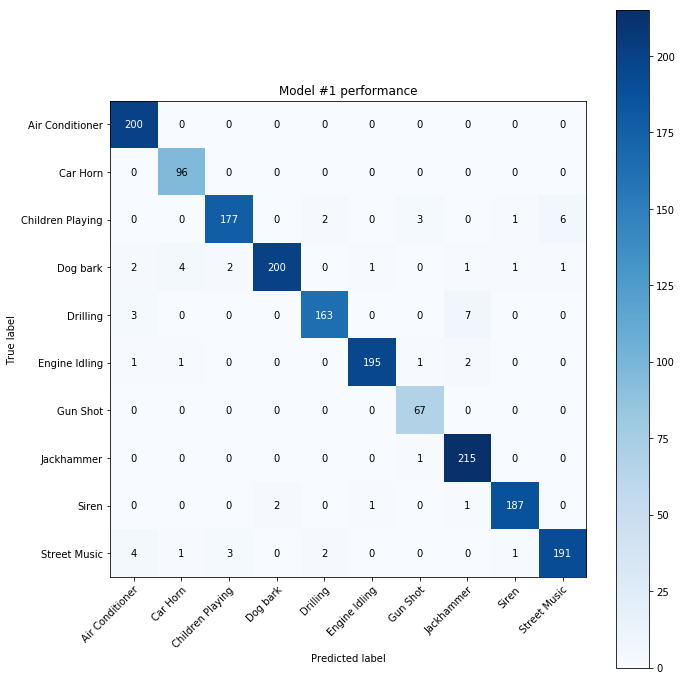

In [511]:
# Ceros after comma (only for printing)
np.set_printoptions(precision=2)

# Class names in the correct order
classes = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

# Ground true classes: index order is preserved!
y_pred = y_test_encoded.argmax(axis=1).tolist()

# Prepare the confusion matrix graph
cm, ax = plot_confusion_matrix(y_pred, preds, 
                          classes,
                          normalize=False,
                          title="Model #1 performance")

# Plot the confusion matrix
plt.show()


#### Observations

We have some classes with 100% accuracy (that were not confussed with any other category):
* Air Conditioner
* Car Horn
* Gun shot

<br/>
There are some interesting cases where the misclassified sample may have very similar patterns to those of the predicted class, for example:<br/>

* 6 Children Playing classified as Street Music, and 3 Street Music as Children Playing
* 4 Dog Barks classified as Car Horn: maybe very short and up-pitched barks?
* 7 Drilling sounds confussed with Jack Hammer: actually the difference between this two classes is subtle, but I was expecting more errors actually!
* 2 Engine Idling samples classified as Jack Hammer: same as above, but still good results.
* 2 Siren sounds classified as Dog Bark: maybe a similar case to the miss classified Dog Barks?


<br/>
How about if we look for those misclassified samples and see if they actually sound like the  false class? Let's go for it:<br/>
<br/>

#### Per class accuracy
Using the data from the consufion matrix we can get the per class accuracy:

In [514]:

# Predicted classes: again, index order is the same
preds = predictions.argmax(axis=1).tolist()

# Find per-class accuracy from the confusion matrix data
accuracies = acc_per_class(cm)

pd.DataFrame({
    'CLASS': classes,
    'ACCURACY': accuracies
})

CLASS    ACCURACY
0   Air Conditioner  100.000000
1          Car Horn  100.000000
2  Children Playing   93.650794
3          Dog bark   94.339623
4          Drilling   94.219653
5     Engine Idling   97.500000
6          Gun Shot  100.000000
7        Jackhammer   99.537037
8             Siren   97.905759
9      Street Music   94.554455

### Exploring the misclassified

In [ ]:
# Lets first add a predictions column to our test metadata so we can access the sound files
test_meta['pred'] = preds

#### 1. Children playing as Street music

In [383]:
print("Children playing as Street music")

# Children Playing as Street Music
children_as_music = test_meta[(test_meta['classID'] == 2) & (test_meta['pred'] == 9)]

files = []
for idx, row in children_as_music.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

# Manully set the file index
index = 5
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

IPython.display.Audio(files[index])

Children playing as Street music

True category: children_playing
File: /home/edu/Projects/urban-audio-classifier/UrbanSound8K/audio/fold2/174906-2-0-14.wav


#### Observations

* In most cases you barely listen to any children playing
* In many cases there is significantly loud rythmic percussive sound, the best example may be: "fold8/72015-2-0-1.wav"
* In several cases you won't hear any chilfren playing instead some adult voices, traffic and loud percussive patterns in the low frequencies

<br/>
<br/>

#### 2. Dog Bark as Car Horn

In [363]:
print("Dog Bark as Car Horn")

# Dog Bark as Car Horn
bark_as_horn = test_meta[(test_meta['classID'] == 3) & (test_meta['pred'] == 1)]

files = []
for idx, row in bark_as_horn.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

# Set the file index
index = 2
   
# Display results
print("\nTrue category: {}\n".format(category))
print("File: {}".format(files[index]))

IPython.display.Audio(files[index])

Dog Bark as Car Horn

True category: dog_bark

File: /home/edu/Projects/urban-audio-classifier/UrbanSound8K/audio/fold1/51022-3-29-0.wav


#### Observations

* All cases are those of short barks, maybe a similar pattern to also short car horn sounds in the dataset
* There's 1 of 4 cases where you can listen to loud traffic at the background mixed with some dog barking; similarly, Car Horn audio in this dataset is generally mixed with loud traffic backgrounds.
* Another 1 of 4 cases in particular has a long and loud high pitched whisle mixed with a very short dog bark.

<br/>
<br/>

#### 3. Siren as Dog Bark

In [368]:
print("Siren as Dog Bark")

# Siren classified as Dog Bark
siren_as_bark = test_meta[(test_meta['classID'] == 8) & (test_meta['pred'] == 3)]

files = []
for idx, row in siren_as_bark.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

# Manully set the file index
index = 0
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

IPython.display.Audio(files[index])

Siren as Dog Bark

True category: siren
File: /home/edu/Projects/urban-audio-classifier/UrbanSound8K/audio/fold4/156868-8-2-0.wav


#### Observations

* In this two particular cases it seems that the short duration -similar to many examples of dog barks in the dataset- and the very similar pitch confussed

<br/>
<br/>

#### 4. Drilling as Jack Hammer

In [382]:
print("Drilling as Jack Hammer")

# Drilling as Jack Hammer
drilling_as_jack = test_meta[(test_meta['classID'] == 4) & (test_meta['pred'] == 7)]

files = []
for idx, row in drilling_as_jack.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

# Manully set the file index
index = 4
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

IPython.display.Audio(files[index])

Drilling as Jack Hammer

True category: drilling
File: /home/edu/Projects/urban-audio-classifier/UrbanSound8K/audio/fold9/58937-4-2-2.wav


#### Observations

We must first state that this are the most similar classes: a continuous percussive sound with a regular frequency. What makes the difference is that Driller's sound is treble and fast while Jack Hammer's bass and treble, being this stated:

* Most of the misclassified sound are drillers generating percussive bass sounds -many modern drillers will have a switch to function as a percussive hammer!
* Some samples actually sound nothing like a driller and everything like a Jack Hammer. Maybe only the speed is faster than the usual Jack Hammer sound and the model did not catch that pattern?

<br/>
<br/>

#### 5. Drilling as Air Conditioner

In [390]:
print("Drilling as Air Conditioner")

# Drilling as Air Conditioner
drilling_as_aircon = test_meta[(test_meta['classID'] == 4) & (test_meta['pred'] == 0)]

files = []
for idx, row in drilling_as_aircon.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

# Manully set the file index
index = 0
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

IPython.display.Audio(files[index])

Drilling as Air Conditioner

True category: drilling
File: /home/edu/Projects/urban-audio-classifier/UrbanSound8K/audio/fold1/17913-4-0-2.wav


#### Observations

In every case you can clearly distinguish a driller but perhaps there's a very subtle pattern I think I have recognized in this cases, that could guided to a misclassification: there are many air conditioners that appart from the typical continuous low amplified sound in the low frequencies, there's also some vibrating sound of oscilating amplitude in the mid-low frequencies.

In all of this misclassified samples I observe the same pattern: the drillers are functioning with some oscillating patterns, like those from *some* of the true class.
<br/>
<br/>

#### 6. Jack Hammer as Gunshot

In [394]:
# Jack Hammer as Gunshot

print("Jack Hammer as Gunshot")

jack_as_gunshot = test_meta[(test_meta['classID'] == 7) & (test_meta['pred'] == 6)]

files = []
for idx, row in jack_as_gunshot.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

# Manully set the file index
index = 0
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

IPython.display.Audio(files[index])

Jack Hammer as Gunshot

True category: jackhammer
File: /home/edu/Projects/urban-audio-classifier/UrbanSound8K/audio/fold2/165775-7-0-0.wav


#### Observations

In this case maybe the very short duration of the audio clip could couse the misclasification. Maybe because all gunshot samples are also very short.
<br/>
<br/>

#### 7. Street Music as Air Conditioner

In [422]:
print("Street Music as Air Conditioner")

# Street Music as Air Conditioner
music_as_aircon = test_meta[(test_meta['classID'] == 9) & (test_meta['pred'] == 0)]

files = []
for idx, row in music_as_aircon.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

# Manully set the file index
index = 3

prediction = predict_from_file(files[index], num_rows, num_columns, num_channels)

print("False positive probability:", prediction[1][0])
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

IPython.display.Audio(files[index])

Street Music as Air Conditioner
False positive probability: 0.666828

True category: street_music
File: /home/edu/Projects/urban-audio-classifier/UrbanSound8K/audio/fold6/31973-9-0-43.wav


#### Observations

In at least two examples the street music sounds very weak in the background and there is much continuous noise in the mid-to-low frequencies. In the first example, in my opinion, there is nothing like music in the sound, it sounds more like street ambience sound. Still, the model is not being capable of recognizing the real class pattern for this few examples.
<br/>
<br/>

## Conclusion

<br/>
Suprisingly, I achieved better results than the expected at the start of the process. There are still some signs that model is not being able to correctly classify data when the objective sound is not loud enough or it competes strongly with other sound sources observed in the same audio sample.<br/>
<br/>
Some particular cases -like air conditioning- may have patterns -like a constant low frequency- that are likely to appear with similarities in other scenarios of outdoors footage.<br/>
<br/>
Rythm patterns where well recognized and distinguished between Drilling and Jack Hammer, and despite of the very little errors, their particular frequencies too.<br/>
<br/>
All that being said, at first I struggled quite a bit to counter overfitting; I got better results once I simplified the model and adding Spatial Dropout.<br/>
<br/>
Once I got 90~91% accuracy on the test set, it started to get hard to raise it further while also keeping the loss difference between Train and Test lower than 4%.
After changing the last two Convolutional layer kernels from (2x2) to (3x3) and later  adjusting the Spatial Dropout a bit, I finally got to 93~94% in the test set.<br/>
<br/>
The next step is to:<br/>

* Add noise to the input and maybe also between layers
* Augmenting data
* Experiment with some more complex architectures

<br/>
<br/>
You may continue to the next notebook: 4-